In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt

In [2]:
project = sg.get_project()

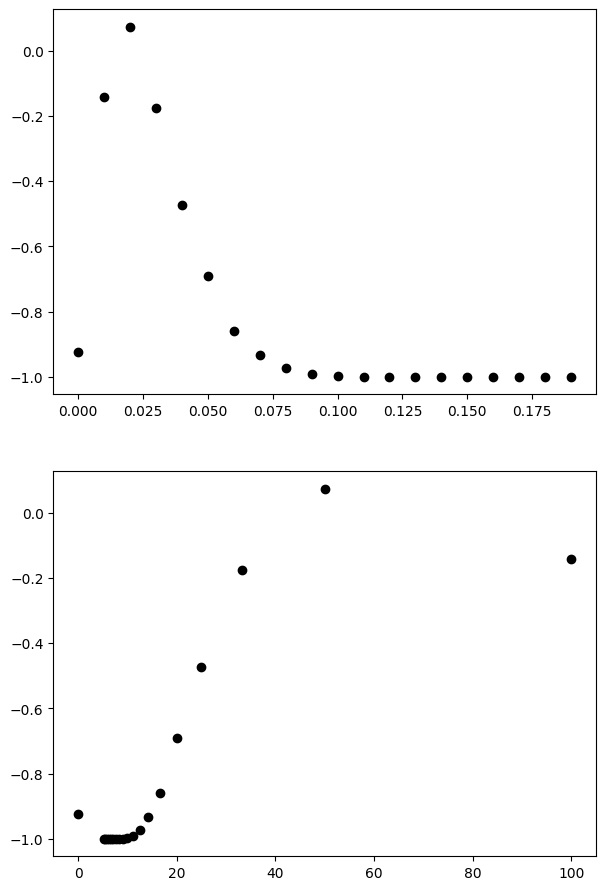

In [101]:
fig, axs = plt.subplots(2, 1, figsize=(7,11))
# for job in project.find_jobs({'fire_prob': 0.17}):
for job in project: 
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        # final_approx = np.mean(final_approx_vec)
        init = N_tot_vec[0,0]
        # y = np.mean(final_approx_vec) / init
        err = np.std(final_approx_vec/init, ddof=1)
        diff_vec = final_approx_vec - init
        y_vec = diff_vec / init
        y = np.mean(y_vec)
        err = np.std(y_vec, ddof=1)
        axs[0].scatter(job.sp.fire_prob, y, color='k')
        # axs[0].errorbar(job.sp.fire_prob, y, yerr=err, color='k', fmt='o')
        # axs[0].set_ylim(-0.5, 6)
        fri = 0 if job.sp.fire_prob==0 else 1/job.sp.fire_prob
        axs[1].scatter(fri, y, color='k')
        # axs[1].errorbar(fri, y, yerr=err, color='k', fmt='o')

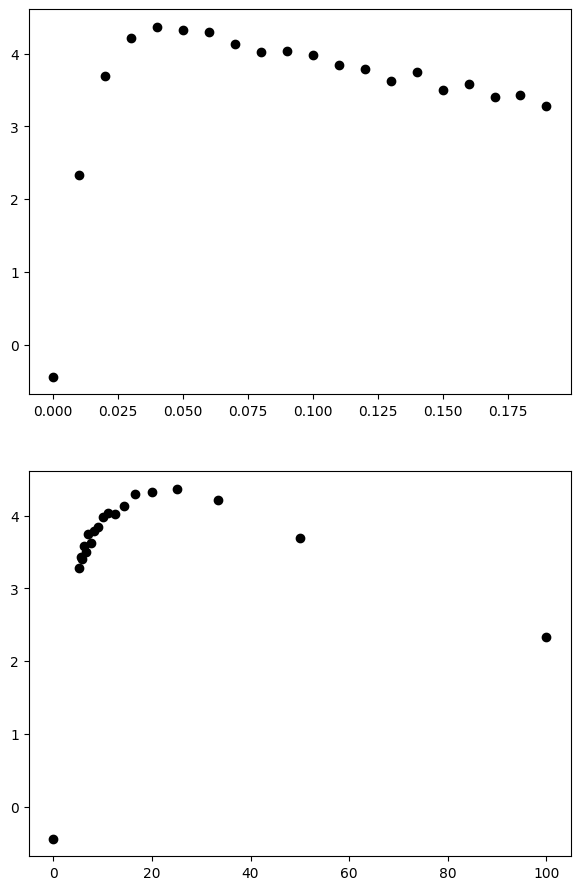

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(7,11))
for job in project:
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,:-20], axis=1)
        # final_approx = np.mean(final_approx_vec)
        init = N_tot_vec[0,0]
        # y = np.mean(final_approx_vec) / init
        # err = np.std(final_approx_vec/init, ddof=1)
        diff_vec = final_approx_vec - init
        y_vec = diff_vec / init
        y = np.mean(y_vec)
        err = np.std(y_vec, ddof=1)
        axs[0].scatter(job.sp.fire_prob, y, color='k')
        # axs[0].errorbar(job.sp.fire_prob, y, yerr=err, color='k', fmt='o')
        # axs[0].set_ylim(-0.5, 6)
        fri = 0 if job.sp.fire_prob==0 else 1/job.sp.fire_prob
        axs[1].scatter(fri, y, color='k')
        # axs[1].errorbar(fri, y, yerr=err, color='k', fmt='o')

(0.0, 20.0)

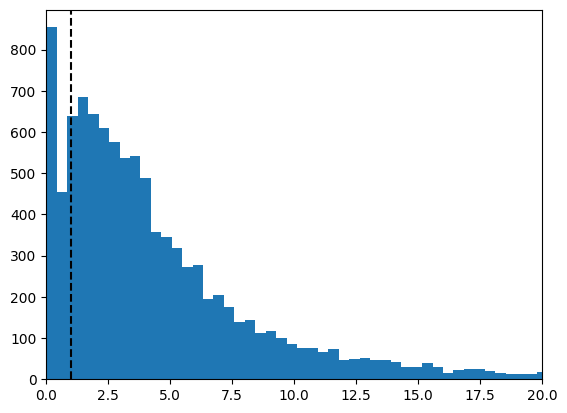

In [82]:
plt.hist(final_approx_vec/init, bins=400);
plt.axvline(1, ls='--', c='k')
plt.xlim(0,20)

In [84]:
for job in project.find_jobs({'fire_prob': 0.02}):
    with job.data as data:
        N_tot_vec = np.array(data['N_tot_vec'])
        final_approx_vec = np.mean(N_tot_vec[:,-20:], axis=1)
        y_vec = final_approx_vec

(-100.0, 5000.0)

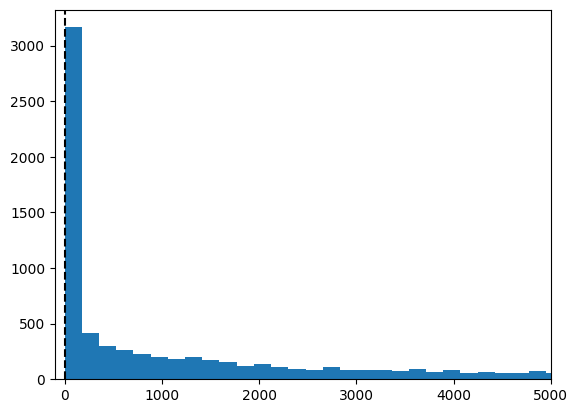

In [88]:
hist = plt.hist(y_vec, bins=5000);
# hist = plt.hist(y_vec, bins=100);
plt.axvline(0, ls='--', c='k')
plt.xlim(-100,5000)

In [79]:
hist

(array([3.165e+03, 4.190e+02, 2.970e+02, ..., 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([0.00000000e+00, 1.76970400e+02, 3.53940800e+02, ...,
        8.84498059e+05, 8.84675030e+05, 8.84852000e+05]),
 <BarContainer object of 5000 artists>)

In [8]:
job

Job(project=Project('/Volumes/External/Research/Regan/TecateCypress/optimal_fire'), statepoint={'fire_prob': 0.1})